## Introduction

1. Explore Data
 + counting well
 + location of wells
2. determine validation method
 + split 10-folds by k-means clustering (using location information - `X_LOC`, `Y_LOC`)
 + create `folds` variable

### Loading Module

In [99]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

### Import dataset & check data
The [data](https://xeek.ai/challenges/force-well-logs/leaderboard) is from competition of xeex. 

In [100]:
df = pd.read_csv(filepath_or_buffer = "./data/train.csv", delimiter = ";")

In [101]:
# counting wells
well_list = df["WELL"].drop_duplicates().to_numpy()
print("The number of wells:", len(well_list))

The number of wells: 98


In [102]:
# step of DEPTH
step_DEPTH = df[["WELL", "DEPTH_MD"]].groupby("WELL").diff().round(decimals = 4).drop_duplicates().reset_index( drop = True )
step_DEPTH.head()
""" The step of DEPTH is not constant """

' The step of DEPTH is not constant '

### Visualization of location

In [103]:
loc_df = df[ ["WELL", "X_LOC", "Y_LOC"] ].groupby("WELL").mean().reset_index()

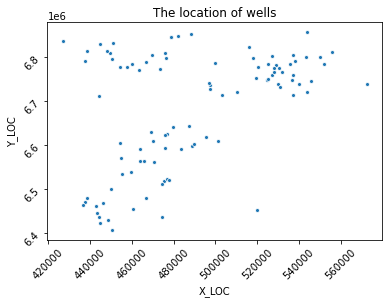

In [104]:
sns.scatterplot(x = "X_LOC", y = "Y_LOC", data = loc_df, s = 15)
plt.title(label = "The location of wells")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

### clustering (by location)
It is assumed that there will be similar characteristics between wells that are geographically close.
Therefore, when performing validation, it is necessary to consider the location of the well.
So, we use k-means method (based on X_LOC, Y_LOC) for creating 10 folds.

In [105]:
X       = loc_df[ ["X_LOC", "Y_LOC"] ]
kmeans  = KMeans(n_clusters = 10, random_state = 0).fit(X)
cluster = kmeans.predict(X)

In [106]:
cluster = [ "cluster" + str(k) for k in cluster ] # rename cluster
cluster_order = [ "cluster" + str(k) for k in range(10) ]
loc_df["FOLDS"] = pd.Categorical(cluster, categories = cluster_order )

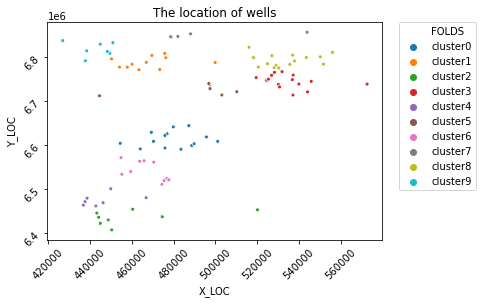

In [107]:
sns.scatterplot(x = "X_LOC", y = "Y_LOC", hue = "FOLDS", hue_order = cluster_order, data = loc_df, s = 15)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title(label = "The location of wells")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

### Output

In [108]:
df_out = pd.merge(left = df, right = loc_df[["WELL", "FOLDS"]], how = "left", on = ["WELL"])

In [109]:
df_out.to_csv(path_or_buf = "./data/train_validation.csv", index = False)